In [23]:
from __future__ import print_function
import tensorflow as tf
import os

# Dataset Parameters - CHANGE HERE
DATASET_PATH = '../data/TRANCOS_v3/'

# Image Parameters
N_CLASSES = 1
IMG_HEIGHT = 112
IMG_WIDTH = 200
CHANNELS = 3


# Reading the dataset
def read_images(dataset_path, batch_size, mode):
    imagepaths, labels = [], []
        # Read dataset file
    if mode == 'train':
        dataset_path_mod = dataset_path + 'image_sets/training.txt'
    elif mode == 'validation':
        dataset_path_mod = dataset_path + 'image_sets/validation.txt'
    elif mode == 'test':
        dataset_path_mod = dataset_path + 'image_sets/test.txt'
        
    with open(dataset_path_mod, 'r') as f:
        data = f.read().splitlines()
        
    for d in data:
        imagepaths.append(dataset_path+'images/'+d)
        
        label = (dataset_path+'images/'+d).replace('.jpg','.txt')
        with open(label, 'r', encoding='utf-8') as f:
            for i, l in enumerate(f):
                pass
            
        labels.append(i+1)

    # Convert to Tensor
    imagepaths = tf.convert_to_tensor(imagepaths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    # Build a TF Queue, shuffle data
    image, label = tf.train.slice_input_producer([imagepaths, labels],
                                                 shuffle=True)

    # Read images from disk
    image = tf.read_file(image)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    # Resize images to a common size
    image = tf.image.resize_images(image, [IMG_HEIGHT, IMG_WIDTH])

    # Normalize
    #image = image * 1.0/127.5 - 1.0 ################################################################### sketchy
    image = tf.image.per_image_standardization(image)
    # Create batches
    X, Y = tf.train.batch([image, label], batch_size=batch_size,
                          capacity=batch_size * 8)#,
                          #num_threads=4) ############################################################# num threads?

    return X, Y

# Parameters
learning_rate = 0.001
num_steps = 1
batch_size = 10
display_step = 100
dropout = 0.75

# Build the data input
X_train_batch, Y_train_batch = read_images(DATASET_PATH, batch_size, mode='train')
X_test_batch, Y_test_batch   = read_images(DATASET_PATH, batch_size, mode='test')
X_val_batch, Y_val_batch     = read_images(DATASET_PATH, batch_size, mode='validation')

# Create model
def conv_net(x, reuse=False):
    # Define a scope for reusing the variables

    conv1    = tf.layers.conv2d(inputs=x, 
                                filters=32, 
                                kernel_size=5,
                                activation=tf.nn.relu)

    maxpool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                       pool_size=2,
                                       strides=2)

    conv2    = tf.layers.conv2d(inputs=maxpool1, 
                                filters=32, 
                                kernel_size=5,
                                activation=tf.nn.relu)

    maxpool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                       pool_size=2,
                                       strides=2)

    conv3    = tf.layers.conv2d(inputs=maxpool2, 
                                filters=32, 
                                kernel_size=3,
                                activation=tf.nn.relu)

    maxpool3 = tf.layers.max_pooling2d(inputs=conv2, 
                                       pool_size=2,
                                       strides=2)

    flat     = tf.contrib.layers.flatten(inputs=maxpool3)

    dropout1 = tf.layers.dropout(inputs=flat, 
                                 rate=dropout, 
                                 training=True)

    fullyconnected1   = tf.layers.dense(inputs=dropout1, 
                               units=500, 
                               activation=tf.nn.relu)

    dropout2 = tf.layers.dropout(inputs=fullyconnected1, 
                                 rate=dropout, 
                                 training=True)
    out = tf.layers.dense(dropout2, 
                          units=1)

    #hidden = tf.layers.dense(inputs=x,
    #                         units=100,
    #                         activation=tf.nn.relu)
    #out = tf.layers.dense(hidden, 1)

    return out



# Because Dropout have different behavior at training and prediction time, we
# need to create 2 distinct computation graphs that share the same weights.

# Create a graph for training
logits_train = conv_net(X_train_batch)
# Create another graph for testing that reuse the same weights
#logits_test = conv_net(X)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op   = tf.reduce_mean(tf.square(tf.subtract(Y_train_batch, logits_train)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op  = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
#test_loss = tf.reduce_mean(tf.square(tf.subtract(Y, logits_test)))
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver object
saver = tf.train.Saver()

In [24]:
with tf.Session() as sess:
  
    # initialize the variables
    sess.run(tf.global_variables_initializer())

    # initialize the queue threads to start to shovel data
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(10):
        #print(sess.run(X_train_batch))
        xinput = sess.run(X_train_batch)
        yinput  = sess.run(Y_train_batch)
        
    coord.request_stop()
    coord.join(threads)

In [25]:
xinput.shape

(10, 112, 200, 3)

In [57]:
from PIL import Image
import numpy as np
index = 1

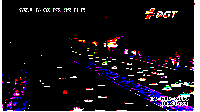

In [58]:
Image.fromarray(np.uint8(xinput[index,:,:,:]), 'RGB')

In [59]:
yinput[index]

14.0